### Resampling, Shifting, and Windowing


In [125]:
import pandas as pd
import numpy as np

In [2]:
pip install pandas_datareader

Note: you may need to restart the kernel to use updated packages.


In [43]:
from pandas_datareader import data
goog = data.DataReader('GOOG', start='2004', end='2016',
                       data_source='yahoo')
goog

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2004-08-19,51.835709,47.800831,49.813290,49.982655,44871361.0,49.982655
2004-08-20,54.336334,50.062355,50.316402,53.952770,22942874.0,53.952770
2004-08-23,56.528118,54.321388,55.168217,54.495735,18342897.0,54.495735
2004-08-24,55.591629,51.591621,55.412300,52.239197,15319808.0,52.239197
2004-08-25,53.798351,51.746044,52.284027,52.802086,9232276.0,52.802086
...,...,...,...,...,...,...
2015-12-24,751.349976,746.619995,749.549988,748.400024,527200.0,748.400024
2015-12-28,762.989990,749.520020,752.919983,762.510010,1515300.0,762.510010
2015-12-29,779.979980,766.429993,766.690002,776.599976,1765000.0,776.599976


In [44]:
google=goog['Close']

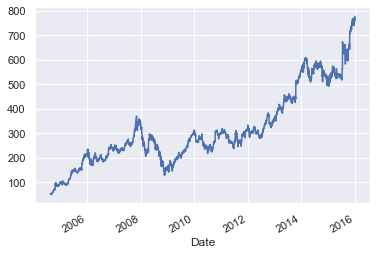

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn;seaborn.set()
google.plot()
# consumes a little time as it's large data 

### Resampling and converting frequencies

One common need for time series data is resampling at a higher or lower frequency.
You can do this using the resample() method, or the much simpler asfreq() method

The primary difference between the two is that resample() is fundamentally
a data aggregation, while asfreq() is fundamentally a data selection.


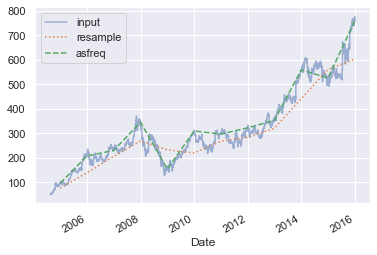

In [46]:
google.plot(alpha=0.5, style='-')
google.resample('BA').mean().plot(style=':')  # BA is Bussiness year end frequency
google.asfreq('BA').plot(style='--');
plt.legend(['input', 'resample', 'asfreq'],
 loc='upper left');

Notice the difference: at each point, resample reports the average of the previous year,
while asfreq reports the value at the end of the year.

For up-sampling, resample() and asfreq() are largely equivalent, though resample
has many more options available. In this case, the default for both methods is to leave
the up-sampled points empty—that is, filled with NA values

In [19]:
google.resample?

In [25]:
google.asfreq?

In [16]:
index = pd.date_range('1/1/2000', periods=9, freq='T')
series = pd.Series(range(9), index=index)
series

2000-01-01 00:00:00    0
2000-01-01 00:01:00    1
2000-01-01 00:02:00    2
2000-01-01 00:03:00    3
2000-01-01 00:04:00    4
2000-01-01 00:05:00    5
2000-01-01 00:06:00    6
2000-01-01 00:07:00    7
2000-01-01 00:08:00    8
Freq: T, dtype: int64

In [17]:
series.resample('3T').sum()

2000-01-01 00:00:00     3
2000-01-01 00:03:00    12
2000-01-01 00:06:00    21
Freq: 3T, dtype: int64

In [18]:
series.resample('3T', label='right').sum()

2000-01-01 00:03:00     3
2000-01-01 00:06:00    12
2000-01-01 00:09:00    21
Freq: 3T, dtype: int64

In [20]:
series.resample('3T', label='right', closed='right').sum()

2000-01-01 00:00:00     0
2000-01-01 00:03:00     6
2000-01-01 00:06:00    15
2000-01-01 00:09:00    15
Freq: 3T, dtype: int64

In [21]:
series.resample('3T')

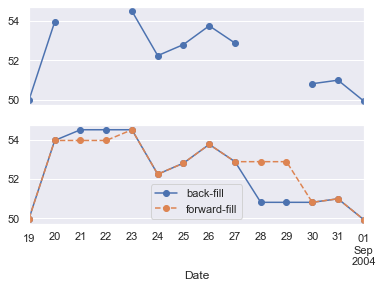

In [48]:
fig, ax = plt.subplots(2, sharex=True)
data = google.iloc[:10]
data.asfreq('D').plot(ax=ax[0], marker='o')
data.asfreq('D', method='bfill').plot(ax=ax[1], style='-o')
data.asfreq('D', method='ffill').plot(ax=ax[1], style='--o')
ax[1].legend(["back-fill", "forward-fill"]);

### Time-shifts

Another common time series–specific operation is shifting of data in time. Pandas
has two closely related methods for computing this: shift() and tshift(). In short,
the difference between them is that shift() shifts the data, while tshift() shifts the
index

Here we will both shift() and tshift() by 900 days

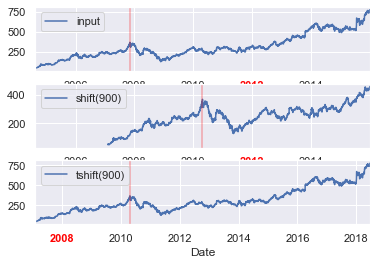

In [151]:
fig, ax = plt.subplots(3)
 # apply a frequency to the data
google = google.asfreq('D', method='pad')
google.plot(ax=ax[0])
google.shift(900).plot(ax=ax[1])
google.tshift(900).plot(ax=ax[2])
 # legends and annotations
local_max = pd.to_datetime('2007-11-05')
offset = pd.Timedelta(900, 'D')
ax[0].legend(['input'], loc=2)
ax[0].get_xticklabels()[4].set(weight='heavy', color='red')
ax[0].axvline(local_max, alpha=0.3, color='red')
ax[1].legend(['shift(900)'], loc=2)
ax[1].get_xticklabels()[4].set(weight='heavy', color='red')
ax[1].axvline(local_max + offset, alpha=0.3, color='red')
ax[2].legend(['tshift(900)'], loc=2)
ax[2].get_xticklabels()[1].set(weight='heavy', color='red')
ax[2].axvline(local_max + offset, alpha=0.3, color='red')

In [54]:
plt.subplots?

A common context for this type of shift is computing differences over time. For
example, we use shifted values to compute the one-year return on investment for
Google stock over the course of the dataset

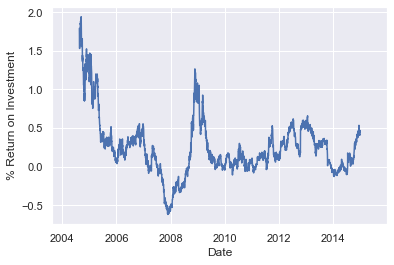

In [50]:
ROI =  (google.tshift(-365) / google - 1)
ROI.plot()
plt.ylabel('% Return on Investment');


### Rolling windows

Rolling statistics are a third type of time series–specific operation implemented by
Pandas. These can be accomplished via the rolling() attribute of Series and Data
Frame objects

 This rolling view makes available
a number of aggregation operations by default

In [63]:
google.rolling?

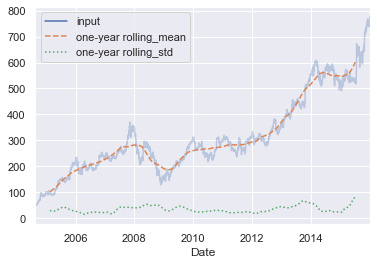

In [61]:
rolling = google.rolling(365, center=True)
data = pd.DataFrame({'input': google,
                     'one-year rolling_mean': rolling.mean(),
                     'one-year rolling_std': rolling.std()})
ax = data.plot(style=['-', '--', ':'])
ax.lines[0].set_alpha(0.3)

In [62]:
data.apply?

In [99]:
data = pd.read_csv(r'C:\Users\gdg13\Downloads\Fremont_Bridge_Bicycle_Counter.csv')
data

,Date,Fremont Bridge Total,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
0,11/01/2019 12:00:00 AM,12.0,7.0,5.0
1,11/01/2019 01:00:00 AM,7.0,0.0,7.0
2,11/01/2019 02:00:00 AM,1.0,0.0,1.0
3,11/01/2019 03:00:00 AM,6.0,6.0,0.0
4,11/01/2019 04:00:00 AM,6.0,5.0,1.0
...,...,...,...,...
142881,06/30/2021 07:00:00 PM,241.0,89.0,152.0
142882,06/30/2021 08:00:00 PM,179.0,73.0,106.0
142883,06/30/2021 09:00:00 PM,102.0,40.0,62.0
142884,06/30/2021 10:00:00 PM,42.0,20.0,22.0


In [106]:
data.index=data['Date']
data=data.drop('Date',axis=1)

In [107]:
data.columns=['Total','West','East']
data.head()

,Total,West,East
Date,,,
11/01/2019 12:00:00 AM,12.0,7.0,5.0
11/01/2019 01:00:00 AM,7.0,0.0,7.0
11/01/2019 02:00:00 AM,1.0,0.0,1.0
11/01/2019 03:00:00 AM,6.0,6.0,0.0
11/01/2019 04:00:00 AM,6.0,5.0,1.0


In [112]:
data.index=pd.to_datetime(data.index)

In [113]:
data.dropna().describe()

,Total,West,East
count,142864.000000,142864.000000,142864.000000
mean,111.083716,50.539667,60.544049
std,141.607196,65.258093,88.019141
min,0.000000,0.000000,0.000000
25%,14.000000,6.000000,7.000000
50%,60.000000,28.000000,30.000000
75%,145.000000,68.000000,74.000000
max,1097.000000,698.000000,850.000000


### Visualizing the data

Text(0, 0.5, 'Hourly total')

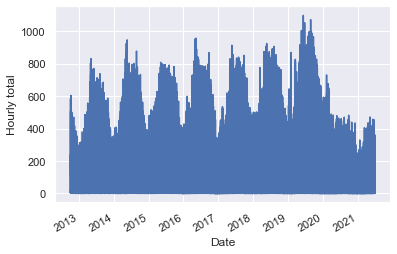

In [114]:
%matplotlib inline
import seaborn;seaborn.set()
data['Total'].plot()
plt.ylabel('Hourly total')

This data is wy too dense to read. Hence, converting the data to weekly now 

Text(0, 0.5, 'Weekly data')

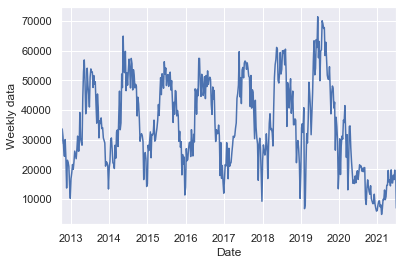

In [115]:
weekly=data.resample('W').sum()
weekly['Total'].plot(style=['-'])
plt.ylabel('Weekly data')

Another way that comes in handy for aggregating the data is to use a rolling mean,
utilizing the pd.rolling_mean() function

Text(0, 0.5, 'mean hourly count')

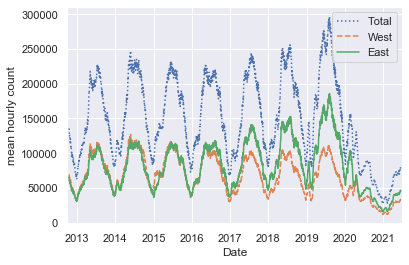

In [117]:
daily = data.resample('D').sum()    # contain all the columns Total,West and East
daily.rolling(30, center=True).sum().plot(style=[':', '--', '-'])
plt.ylabel('mean hourly count')

Text(0, 0.5, 'mean hourly count')

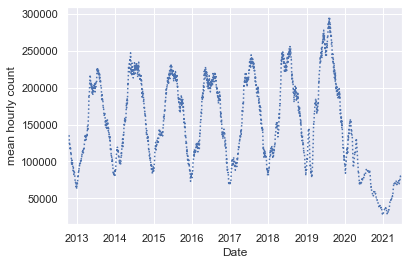

In [118]:
daily = data.resample('D').sum()
daily['Total'].rolling(30, center=True).sum().plot(style=[':', '--', '-'])
plt.ylabel('mean hourly count')

The jaggedness of the result is due to the hard cutoff of the window. We can get a
smoother version of a rolling mean using a window function—for example, a Gaussian window

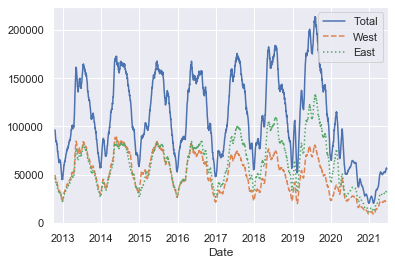

In [122]:
daily.rolling(30,center=True,win_type='gaussian').sum(std=10).plot(style=['-','--',':'])
# The curve is now smooth enough

### Digging into the data


While the smoothed data views in Figure  are useful to get an idea of the general
trend in the data, they hide much of the interesting structure. For example, we might
want to look at the average traffic as a function of the time of day.

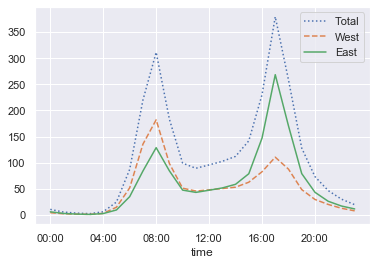

In [130]:
by_time = data.groupby(data.index.time).mean()
hourly_ticks = 4 *60 * 60 * np.arange(6)
by_time.plot(xticks=hourly_ticks, style=[':', '--', '-']);


In [132]:
data.groupby?

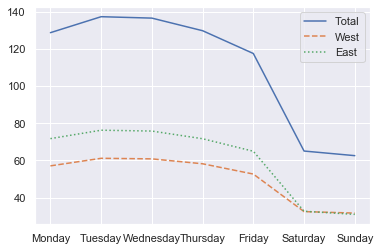

In [133]:
by_weekday=data.groupby(data.index.dayofweek).mean()
by_weekday.index=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
by_weekday.plot(style=['-','--',':'])

In [141]:
np.where?

In [136]:
weekend = np.where(data.index.weekday < 5, 'Weekday', 'Weekend')
by_time = data.groupby([weekend, data.index.time]).mean()


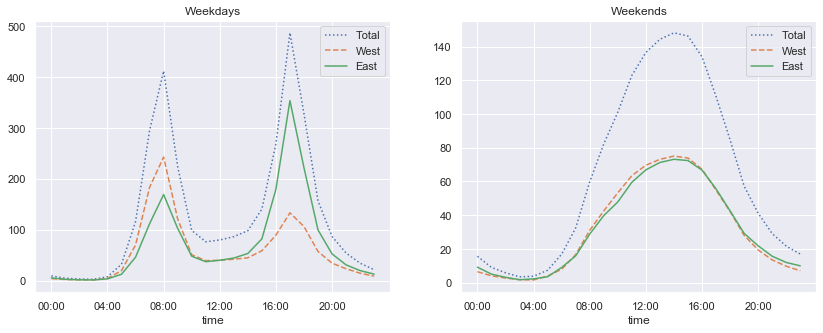

In [150]:
import matplotlib.pyplot as plt    # This figsize is used to increase or decrease the size of figure
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
by_time.loc['Weekday'].plot(ax=ax[0], title='Weekdays',       # just changed .ix by .loc
                           xticks=hourly_ticks, style=[':', '--', '-'])
by_time.loc['Weekend'].plot(ax=ax[1], title='Weekends',
                           xticks=hourly_ticks, style=[':', '--', '-'])

In [142]:
by_time

Total        West        East
Weekday 00:00:00    9.186178    3.929008    5.257170
        01:00:00    4.551951    2.035026    2.516925
        02:00:00    3.027504    1.485190    1.542313
        03:00:00    2.595910    1.350729    1.245181
        04:00:00    7.444523    4.070287    3.374236
        05:00:00   32.160790   19.709450   12.451340
        06:00:00  115.750588   69.869770   45.880818
        07:00:00  294.831688  183.198872  111.632816
        08:00:00  411.655853  242.624824  169.031030
        09:00:00  223.764346  121.154280  102.610066
        10:00:00   98.617357   50.777516   47.839840
        11:00:00   76.223424   39.155456   37.067968
        12:00:00   79.767874   39.845720   39.922154
        13:00:00   86.266573   42.003056   44.263517
        14:00:00   97.994122   44.746532   53.247590
        15:00:00  140.330355   58.525747   81.804609
        16:00:00  268.553021   89.203151  179.349871
        17:00:00  486.584764  133.070303  353.514460
        18:00:00  327.820362  106.147190  221.673172
        19:00:00  156.554432   57.130026   99.424406
        20:00:00   86.619092   34.199624   52.419469
        21:00:00   54.088878   23.255584   30.833294
        22:00:00   34.120386   14.496826   19.623560
        23:00:00   21.286856    8.652481   12.634376
Weekend 00:00:00   15.573529    6.451765    9.121765
        01:00:00    8.961765    3.981176    4.980588
        02:00:00    5.793594    2.675563    3.118031
        03:00:00    3.360588    1.682941    1.677647
        04:00:00    3.724706    1.540588    2.184118
        05:00:00    7.303529    3.856471    3.447059
        06:00:00   16.814118    7.862941    8.951176
        07:00:00   32.403529   16.542941   15.860588
        08:00:00   59.785294   31.013529   28.771765
        09:00:00   82.241765   42.518235   39.723529
        10:00:00  101.057059   53.251176   47.805882
        11:00:00  122.885882   63.397059   59.488824
        12:00:00  136.481765   69.612941   66.868824
        13:00:00  144.322941   73.095882   71.227059
        14:00:00  148.137059   75.010588   73.126471
        15:00:00  146.259412   73.891765   72.367647
        16:00:00  133.903529   67.206471   66.697059
        17:00:00  110.403529   54.828235   55.575294
        18:00:00   84.678824   42.151765   42.527059
        19:00:00   57.211176   28.017647   29.193529
        20:00:00   41.121765   19.334706   21.787059
        21:00:00   29.057059   13.435882   15.621176
        22:00:00   21.601176    9.688235   11.912941
        23:00:00   16.892941    6.974706    9.918235

In [145]:
weekend

array(['Weekday', 'Weekday', 'Weekday', ..., 'Weekday', 'Weekday',
       'Weekday'], dtype='<U7')

In [148]:
by_time.loc['Weekend']

,Total,West,East
00:00:00,15.573529,6.451765,9.121765
01:00:00,8.961765,3.981176,4.980588
02:00:00,5.793594,2.675563,3.118031
03:00:00,3.360588,1.682941,1.677647
04:00:00,3.724706,1.540588,2.184118
05:00:00,7.303529,3.856471,3.447059
06:00:00,16.814118,7.862941,8.951176
07:00:00,32.403529,16.542941,15.860588
08:00:00,59.785294,31.013529,28.771765
09:00:00,82.241765,42.518235,39.723529
